# ML Experiments

In [ ]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import os
from datetime import datetime
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler

In [3]:
%aimport src.utils
from src.utils import summarize_df

## About

This notebook will run ML experiments on the data with features prepared in `7_feat_engineering.ipynb`. The test data will cover 2 months of inspections.

## User Inputs

In [ ]:
trained_model_fname = "trained_model"

## Load Transformed Data

We'll load the processed data engineered features

In [4]:
%%time
df_full = pd.read_csv(
    glob(f"data/processed/processed_with_features__*.csv")[-1],
    parse_dates=["inspection_date"],
).sort_values(
    by=[
        "establishment_id",
        "establishmenttype",
        "establishment_address",
        "inspection_date",
    ],
    ignore_index=True,
)
with pd.option_context("display.max_columns", 1000):
    display(df_full.head(2))
with pd.option_context("display.max_rows", 1000):
    summarize_df(df_full)

,establishment_id,establishmenttype,establishment_address,inspection_id,inspection_date,establishment_status,infractions_summary,num_significant,num_crucial,num_minor,num_na,num_infractions,action_null,num_corrected_during_inspection,num_notice_to_comply,num_ticket,num_summons,num_summons_and_health_hazard_order,num_closure_order,num_not_in_compliance,num_order,num_education_provided,num_warning_letter,num_recommendations,num_prohibition_order_requested,court_outcome_null,num_conviction_fined,num_pending,num_charges_withdrawn,num_conviction_suspended_sentence,num_conviction_ordered_to_close_by_court,num_charges_dismissed,num_charges_quashed,num_conviction_probationary_order,num_cancelled,num_conviction_fined_order_to_close_by_court,is_infraction,latitude,longitude,AREA_NAME,Shape__Area,neigh_shape_area,neigh_shape_length,neigh_classification,neigh_classification_code,neigh_establishments_inspected,neigh_pop,pop_census_year,neigh_Assault,neigh_Auto Theft,neigh_Break and Enter,neigh_Robbery,neigh_Theft Over,time_since_last_infrac,last_pass,last_cond_pass,num_minor_prev,num_significant_prev,num_crucial_prev,num_action_null_prev,num_action_corrected_during_inspection_prev,num_action_notice_to_comply_prev,num_action_ticket_prev,num_action_summons_prev,num_action_summons_and_health_hazard_order_prev,num_action_closure_order_prev,num_action_not_in_compliance_prev,num_action_order_prev,num_action_education_provided_prev,num_action_warning_letter_prev,num_action_recommendations_prev,num_action_prohibition_order_requested_prev,num_court_outcome_null_prev,num_court_outcome_conviction_fined_prev,num_court_outcome_pending_prev,num_court_outcome_charges_withdrawn_prev,num_court_outcome_conviction_suspended_sentence_prev,num_court_outcome_conviction_ordered_to_close_by_court_prev,num_court_outcome_charges_dismissed_prev,num_court_outcome_charges_quashed_prev,num_court_outcome_conviction_probationary_order_prev,num_court_outcome_cancelled_prev,num_court_outcome_conviction_fined_order_to_close_by_court_prev,cumulative_failures,cumulative_minor,cumulative_significant,cumulative_crucial,cumulative_num_action_null_prev,cumulative_num_action_corrected_during_inspection_prev,cumulative_num_action_notice_to_comply_prev,cumulative_num_action_ticket_prev,cumulative_num_action_summons_prev,cumulative_num_action_summons_and_health_hazard_order_prev,cumulative_num_action_closure_order_prev,cumulative_num_action_not_in_compliance_prev,cumulative_num_action_order_prev,cumulative_num_action_education_provided_prev,cumulative_num_action_warning_letter_prev,cumulative_num_action_recommendations_prev,cumulative_num_action_prohibition_order_requested_prev,cumulative_num_court_outcome_null_prev,cumulative_num_court_outcome_conviction_fined_prev,cumulative_num_court_outcome_pending_prev,cumulative_num_court_outcome_charges_withdrawn_prev,cumulative_num_court_outcome_conviction_suspended_sentence_prev,cumulative_num_court_outcome_conviction_ordered_to_close_by_court_prev,cumulative_num_court_outcome_charges_dismissed_prev,cumulative_num_court_outcome_charges_quashed_prev,cumulative_num_court_outcome_conviction_probationary_order_prev,cumulative_num_court_outcome_cancelled_prev,cumulative_num_court_outcome_conviction_fined_order_to_close_by_court_prev,ever_failed,ever_minor,ever_significant,ever_crucial,cumulative_inspections,proportion_past_failures,proportion_past_minor,proportion_past_significant,proportion_past_crucial,days_since_last_inspection,last_inspection_month,last_inspection_weekday,last_inspection_weekofyear,last_inspection_quarter,last_inspection_year,inspection_month,inspection_weekday,inspection_weekofyear,inspection_quarter,inspection_year
0,1222579,Food Take Out,870 MARKHAM RD,102810896,2012-08-21,Pass,NaN,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,43.768,-79.229,Woburn (137),2.366499e+07,2.366499e+07,25089.815423,Neighbourhood Improvement Area,NIA,358.0,NaN,2006.0,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,

,dtype,num_missing,num,nunique,single_non_nan_value
establishment_id,int64,0,205753,27860,10359713
establishmenttype,object,0,205753,56,Restaurant
establishment_address,object,0,205753,13314,3120 DUFFERIN ST
inspection_id,int64,0,205753,205270,104475041
inspection_date,datetime64[ns],0,205753,2481,2019-05-17 00:00:00
establishment_status,object,0,205753,3,Pass
infractions_summary,object,121539,205753,30717,Operate food premise - equipment not arranged ...
num_significant,float64,0,205753,35,0.0
num_crucial,float64,0,205753,15,0.0
num_minor,float64,0,205753,25,2.0


CPU times: user 1.8 s, sys: 180 ms, total: 1.98 s
Wall time: 1.98 s


## Feature Selection

Due to the large number of features in the processed data, we will manually select a subset of these for use in this iteration of ML experiments.

We will also keep in mind that since we are looking to predict infractions ahead of time, we can't use features (data) that won't be available to use until after the desired prediction date. More discussion about this is in the **Background** section of `1_get_data.ipynb`. As a brief example, if we don't know the the number of crimes committed in the future in a neighbourhood, then we can't use this feature as is - we would have to first forecast the number of crimes for the prediction period and it can then be used as an input feature to an ML model. So, for the current iteration of ML experiments, we will exclude crime-related features.

A list of features selected is shown below

In [5]:
f = [
    "AREA_NAME",
    "Shape__Area",
    "neigh_shape_length",
    "time_since_last_infrac",
    "last_pass",
    "last_cond_pass",
    "num_minor_prev",
    "num_significant_prev",
    "num_crucial_prev",
    # 'num_action_null_prev',
    # 'num_action_corrected_during_inspection_prev',
    # 'num_action_notice_to_comply_prev',
    # 'num_action_ticket_prev',
    # 'num_action_summons_prev',
    # 'num_action_summons_and_health_hazard_order_prev',
    # 'num_action_closure_order_prev',
    # 'num_action_not_in_compliance_prev',
    # 'num_action_order_prev',
    # 'num_action_education_provided_prev',
    # 'num_action_warning_letter_prev',
    # 'num_action_recommendations_prev',
    # 'num_action_prohibition_order_requested_prev',
    # 'num_court_outcome_null_prev',
    # 'num_court_outcome_conviction_fined_prev',
    # 'num_court_outcome_pending_prev',
    # 'num_court_outcome_charges_withdrawn_prev',
    # 'num_court_outcome_conviction_suspended_sentence_prev',
    # 'num_court_outcome_conviction_ordered_to_close_by_court_prev',
    # 'num_court_outcome_charges_dismissed_prev',
    # 'num_court_outcome_charges_quashed_prev',
    # 'num_court_outcome_conviction_probationary_order_prev',
    # 'num_court_outcome_cancelled_prev',
    # 'num_court_outcome_conviction_fined_order_to_close_by_court_prev',
    "cumulative_failures",
    "cumulative_minor",
    "cumulative_significant",
    "cumulative_crucial",
    # 'cumulative_num_court_outcome_null_prev',
    # 'cumulative_num_court_outcome_conviction_fined_prev',
    # 'cumulative_num_court_outcome_pending_prev',
    # 'cumulative_num_court_outcome_charges_withdrawn_prev',
    # 'cumulative_num_court_outcome_conviction_suspended_sentence_prev',
    # 'cumulative_num_court_outcome_conviction_ordered_to_close_by_court_prev',
    # 'cumulative_num_court_outcome_charges_dismissed_prev',
    # 'cumulative_num_court_outcome_charges_quashed_prev',
    # 'cumulative_num_court_outcome_conviction_probationary_order_prev',
    # 'cumulative_num_court_outcome_cancelled_prev',
    # 'cumulative_num_court_outcome_conviction_fined_order_to_close_by_court_prev',
    "ever_failed",
    "ever_minor",
    "ever_significant",
    "ever_crucial",
    "cumulative_inspections",
    # "proportion_past_failures",
    # "proportion_past_minor",
    # "proportion_past_significant",
    # "proportion_past_crucial",
    "days_since_last_inspection",
    "last_inspection_month",
    "last_inspection_weekday",
    "last_inspection_weekofyear",
    "last_inspection_quarter",
    "last_inspection_year",
    "inspection_month",
    "inspection_weekday",
    "inspection_weekofyear",
    "inspection_quarter",
    "inspection_year",
    # 'cumulative_num_action_null_prev',
    # 'cumulative_num_action_corrected_during_inspection_prev',
    # 'cumulative_num_action_notice_to_comply_prev',
    # 'cumulative_num_action_ticket_prev',
    # 'cumulative_num_action_summons_prev',
    # 'cumulative_num_action_summons_and_health_hazard_order_prev',
    # 'cumulative_num_action_closure_order_prev',
    # 'cumulative_num_action_not_in_compliance_prev',
    # 'cumulative_num_action_order_prev',
    # 'cumulative_num_action_education_provided_prev',
    # 'cumulative_num_action_warning_letter_prev',
    # 'cumulative_num_action_recommendations_prev',
    # 'cumulative_num_action_prohibition_order_requested_prev'
    "is_infraction",
]
len(f)

30

## Missing Values

The missing values in the manually selected features are shown below

In [6]:
df_full[f].isna().sum().to_frame()

,0
AREA_NAME,6
Shape__Area,6
neigh_shape_length,6
time_since_last_infrac,28233
last_pass,0
last_cond_pass,0
num_minor_prev,28233
num_significant_prev,28233
num_crucial_prev,28233
cumulative_failures,0


Sort values by establishment and inspection

In [9]:
index_cols = [
    "establishment_id",
    "establishmenttype",
    "establishment_address",
    "inspection_id",
    "inspection_date",
]
df = df_full.sort_values(by=index_cols).set_index(index_cols)[f]

For establishments that have never been previously inspected, there was no `last_inspection_month`, resulting in a missing value in this column. These are all counts (eg. `num_significant_prev`) or integers (eg. `last_inspection_weekofyear`), so these columns can be filled with zeros. The implication of this is that if an establishment is inspected multiple times in the test data, it will always appear with zeros in this column, even though the second and subsequent inspections should have a non-zero value. This is a limitation of filling missing values in this column with zeros.

There are also a few inspections where the neighbourhood name could not be extracted. These will be dropped.

In [11]:
df.isna().sum().rename("num_missing").to_frame()

,num_missing
AREA_NAME,6
Shape__Area,6
neigh_shape_length,6
time_since_last_infrac,28233
last_pass,0
last_cond_pass,0
num_minor_prev,28233
num_significant_prev,28233
num_crucial_prev,28233
cumulative_failures,0


Drop missing values in the neighbourhood (`AREA_NAME`) column and fill missing values in other columns with zeros

In [12]:
df = df.dropna(subset=["AREA_NAME"])
df = df.fillna(0)

In [13]:
df.isna().sum().rename("num_missing").to_frame()

,num_missing
AREA_NAME,0
Shape__Area,0
neigh_shape_length,0
time_since_last_infrac,0
last_pass,0
last_cond_pass,0
num_minor_prev,0
num_significant_prev,0
num_crucial_prev,0
cumulative_failures,0


## Split Data

Choose the last two months (60 days) of inspections to be the testing split and keep all preceeding data as the training data
- other applications of ML for food inspections have variable out-of-sample period lengths, so there doesn't appear to be a fixed duration used (rather, it will depend on how far ahead the DineSafe program organizers would be comfortable creating a schedule for future inspections)

In [14]:
train, test = [
    (
        df.loc[
            slice(None),
            slice(None),
            slice(None),
            slice(None),
            slice(
                None,
                df.reset_index(level=4)["inspection_date"].max()
                - pd.Timedelta(60 + 1, unit="days"),
            ),
        ].copy()
    ),
    (
        df.loc[
            slice(None),
            slice(None),
            slice(None),
            slice(None),
            slice(
                df.reset_index(level=4)["inspection_date"].max()
                - pd.Timedelta(60, unit="days"),
                None,
            ),
        ].copy()
    ),
]
print(len(train), len(test))

201017 4730


Show the max train date and min test date

In [15]:
print(
    "Max Train date = {}, Min Test date = {}".format(
        train.reset_index(level=4)["inspection_date"].max().strftime("%Y-%m-%d"),
        test.reset_index(level=4)["inspection_date"].min().strftime("%Y-%m-%d"),
    )
)

Max Train date = 2019-08-23, Min Test date = 2019-08-24


## Filter out Non-Operating Businesses from Test Data

We'll now remove establishments from the test data that are out of business. As a proxy for this, we'll consider establishments that are in operation to be those that have been inspected since Nov 1, 2017 (approx. two years earlier that the last inspection date in the training data). As an alternative, we could use the city of Toronto's [Business License and Permits dataset](https://open.toronto.ca/dataset/municipal-licensing-and-standards-business-licences-and-permits/) to remove businesses with a cancelled permit.

Using the training data, get establishments that have been inspected since Nov 1, 2017

In [16]:
train_post_2017_inspections = (
    train.reset_index()
    .groupby(
        ["establishment_id", "establishmenttype", "establishment_address"],
        as_index=False,
    )["inspection_date"]
    .max()
    .query("inspection_date >= '2017-11-01'")
)
train_post_2017_inspections

,establishment_id,establishmenttype,establishment_address,inspection_date
0,1222579,Food Take Out,870 MARKHAM RD,2019-05-13
2,1222807,Restaurant,1635 LAWRENCE AVE W,2019-06-28
3,1223056,Restaurant,606 BROWNS LINE,2019-03-05
4,1223438,Food Take Out,500 REXDALE BLVD,2019-07-04
7,9000004,Food Take Out,1788 JANE ST,2019-06-04
...,...,...,...,...
27858,10684059,Food Court Vendor,5150 YONGE ST,2019-08-23
27859,10684064,Restaurant,5000 YONGE ST,2019-08-23
27860,10684095,Restaurant,901 DIXON RD,2019-08-23
27861,10684314,Restaurant,6 COXWELL AVE,2019-08-23


We want to keep all establishments in the training data since we want the ML model to learn from all inspections that have been completed. So, we will only remove these establishments (if present) from the testing data since we can't inspect an out-of-business establishment that is no longer open or operational.

Below, we keep inspections in the testing data for establishments with an inspection (in the training data) since Jan 1, 2017

In [17]:
test = (
    test.reset_index()
    .merge(
        train_post_2017_inspections.drop(columns=["inspection_date"]),
        on=[
            "establishment_id",
            "establishmenttype",
            "establishment_address",
        ],
        how="left",
    )
    .set_index(
        [
            "establishment_id",
            "establishmenttype",
            "establishment_address",
            "inspection_id",
            "inspection_date",
        ]
    )
)

## Feature Transformations

We'll define two preliminary lists of numerical and categorical features below

In [18]:
nums = [
    "time_since_last_infrac",
    "days_since_last_inspection",
    "cumulative_minor",
    "cumulative_significant",
    "cumulative_crucial",
    "cumulative_inspections",
    "num_minor_prev",
    "num_significant_prev",
    "num_crucial_prev",
    "cumulative_failures",
]
cats = [
    "AREA_NAME",
    "last_pass",
    "last_cond_pass",
    "ever_failed",
    "ever_minor",
    "ever_significant",
    "ever_crucial",
    "last_inspection_month",
    "last_inspection_weekday",
    "last_inspection_weekofyear",
    "last_inspection_quarter",
    "last_inspection_year",
    "inspection_month",
    "inspection_weekday",
    "inspection_weekofyear",
    "inspection_quarter",
    "inspection_year",
]

In the numericals, there are two features giving a difference in time since the last inspection / infraction. These seem intuitively like numericals.

The other numerical features are cumulative counts or the number of infractions of a certain type. We'll show the five most frequent values in each of these columns

In [19]:
nums2cat = list(
    set(nums) - set(["time_since_last_infrac", "days_since_last_inspection"])
)
nums2cat

['cumulative_significant',
 'num_crucial_prev',
 'cumulative_failures',
 'cumulative_minor',
 'num_minor_prev',
 'num_significant_prev',
 'cumulative_crucial',
 'cumulative_inspections']

In [20]:
for c in nums2cat:
    display(train[c].value_counts().nlargest(5).to_frame())

,cumulative_significant
0.0,95622
3.0,11146
4.0,8753
2.0,8517
6.0,7730


,num_crucial_prev
0.0,196389
1.0,1102
3.0,1063
2.0,952
4.0,575


,cumulative_failures
0,199893
1,1073
2,51


,cumulative_minor
0.0,84433
3.0,10235
2.0,8257
4.0,7829
6.0,6940


,num_minor_prev
0.0,143388
3.0,14642
4.0,9180
6.0,8863
2.0,8222


,num_significant_prev
0.0,165780
3.0,9010
4.0,5631
2.0,5343
6.0,4692


,cumulative_crucial
0.0,175242
1.0,5716
2.0,4387
3.0,4179
4.0,2731


,cumulative_inspections
0,27863
1,23655
2,20376
3,17620
4,15074


**Observations**
1. For all of these features except for `cumulative_inspections`, there is one value (`0`) that is assigned to more than 10 times as many inspections as the next highest value. So, for all these features, we'll change each of these into a categorical feature that is a boolean (True if greater than `0` and False if equal to `0`). These will then be treated as categorical features. Having a value of False means the establishment has had no inspections to-date, while True means that the establishment has been inspected before.

Transform cumulative and count-based features into binary features

In [21]:
for c in nums2cat:
    train[f"{c}_gt_zero"] = train[c] > 0

We'll now add these new binary features to the list of categoricals

In [22]:
cats += nums2cat

We'll create a new list of numericals with only the two features based on a time difference

In [23]:
nums = ["time_since_last_infrac", "days_since_last_inspection"]

## Feature Pre-Processing

Histograms of the two numerical features before and after a power transformation (using the Yeo-Johnson implementation) are shown below

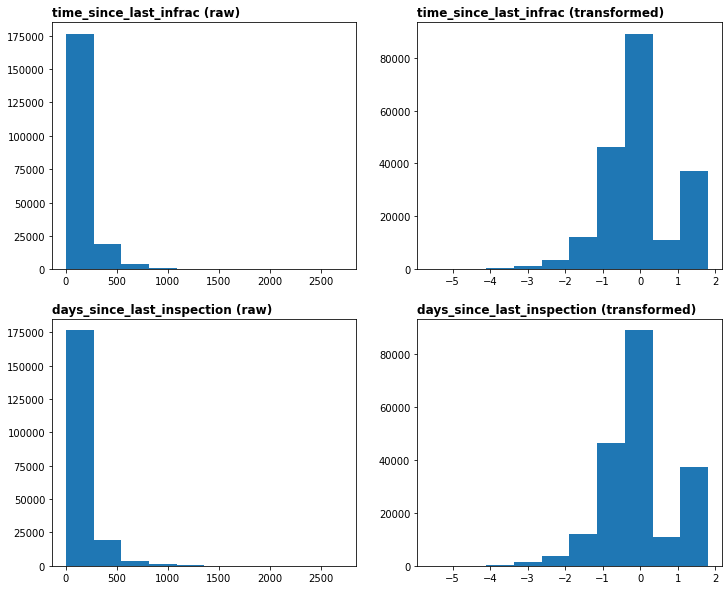

In [24]:
fig = plt.figure(figsize=(12, 10))
grid = plt.GridSpec(2, 2, hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1])
ax3 = fig.add_subplot(grid[1, 0])
ax4 = fig.add_subplot(grid[1, 1])

for k, (ax, data_type) in enumerate(
    zip([ax1, ax2, ax3, ax4], ["raw", "transformed", "raw", "transformed"])
):
    c = nums[0] if k in [0, 2] else nums[1]
    ptitle = f"{nums[0]} ({data_type})" if k in [0, 1] else f"{nums[1]} ({data_type})"
    if k in [0, 2]:
        train[c].plot(kind="hist", ax=ax)
    else:
        pd.Series(
            PowerTransformer(method="yeo-johnson").fit_transform(train[[c]]).flatten()
        ).plot(kind="hist", ax=ax)
    ax.set_title(ptitle, loc="left", fontweight="bold")
    ax.set_xlabel(None)
    ax.set_ylabel(None)

**Notes**
1. The power transformation has improved the distribution of these features, making them more Gaussian-shaped, so we'll use this as the transformation for the numerical features. The `method` of transformation (currently Yeo-Johnson) is a hyper-parameter that can be optimized. These numerical features will then be standardized.

We will apply one-hot encoding to all categorical features.

The following will the be the components of a ML pipeline's pre-processing step

In [25]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
numerical_pipe = Pipeline(
    [("transformer", PowerTransformer(method="yeo-johnson")), ("ss", StandardScaler())]
)

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, cats),
        ("num", numerical_pipe, nums),
    ]
)

## Separate Features from Class Labels

We'll separate the features (`X`) from the class labels (`y`) in both the training and testing splits

In [26]:
X_train, X_test = [train[nums + cats], test[nums + cats]]
y_train, y_test = [train["is_infraction"], test["is_infraction"]]

## Choice of Scoring Metric

We are trying to predict if an inspection will produce a significant or crucial infraction ahead of the actual inspection. By predicting ahead of time, this will reduce the likelihood of customers getting sick. With this in mind, we can say the following about how we should assess the predictions made by an ML model
- TP (true positives)
  - the ML model predicts the detection of an infraction and there really was an infraction during the actual inspection by an inspector
  - establishment owner will be notified that DineSafe has flagged their establishment for an infraction and an inspector will be dispatched immediately to perform a physical inspection
    - owner should be notified to start checking for compliance with all their policies and operating procedures immediately
  - inspector will perform the inspection at such establishments (as soon as our ML model makes its prediction)
    - the immediate inspection by an inspector is needed to verify that there is an infraction at the establishment and enforce an appropriate action on the owner of the establishment
  - we want to maximize this
- TN (true negatives)
  - predicted no infraction and there is no infraction
  - inspector will not perform the inspection and this is not a problem since there is actually no infraction
    - no message will be sent to the establishment owner
  - this is not important
- FP (false positives)
  - predicted infraction but there was no infraction
  - establishment owner will be notified immediately that DineSafe has flagged their establishment for an infraction and inspector has been dispatched to perform the inspection (as soon as our ML model makes its prediction
    - if the establishment was due for an inspection anyway, then this is not a problem
    - if the establishment was not scheduled to be inspected, then the inspector made an unnecessary trip to the establishment but no customers health is negatively affected (since an infraction is not detected)
  - nice to minimize this, but not important
- FN (false negatives)
  - predicted no infraction but there really was an infraction (significant or crucial)
    - such an infraction presents a potential or immediate health risk
  - this means we missed a chance to catch infractions ahead of time
  - inspector does not perform the inspection ahead of time, but should have done so since there is actually an infraction
    - additoinally, the establishment owner should have been notified immediately about their establishment being flagged so that they could start checking that they are following all their policies and operating procedures
  - we want to minimize this

So, TP should be maximized (high precision) and FN should be minimized (high recall). Both are equally important. With this in mind, the `f1-score` will be used as the scoring metric.

The ML model should predict class labels and then, for the predictions of an infraction, the prediction probabilities should be used to create an inspection order for the inspections to be performed. The higher the probability the higher the likelihood of an infraction so the inspectors should prioritize performing a physical inspection for inspections with the highest predicted probabilities for an infraction as soon as the ML model makes its predictions.

## ML Model Selection using Cross-Validation

To pick a ML model, a custom k-fold cross-validation function will be used to split the training data, fit a pipeline to the training fold and score its predictions on the training and validtion fold. The best ML model will be chosen to be the one with the highest f1-score (which represents a balance between recall and precision, with each of these two metrics making an equal contribution as we require for this use-case).

Define the starting date for each validation fold to be used in cross-validation

In [27]:
val_fold_starts = [
    "2018-07-01",
    "2018-10-01",
    "2019-01-01",
    "2019-04-01",
    "2019-07-01",
]

Split the training data into multiple training and validation folds. Each fold is split by date and then randomized

In [28]:
%%time
folds = []
for n, s in enumerate(val_fold_starts):
    # Validation fold start and end dates
    start_date = pd.to_datetime(s)
    end_date = start_date + pd.Timedelta(60, unit="days")

    # Get train and validation folds
    X_train_cv = (
        X_train.reset_index()
        .sort_values(by=index_cols)
        .set_index(index_cols)
        .loc[
            slice(None),
            slice(None),
            slice(None),
            slice(None),
            slice(pd.to_datetime("2017-01-01"), start_date - pd.Timedelta(1, unit="days")),
        ]
    )
    y_train_cv = (
        y_train.reset_index()
        .sort_values(by=index_cols)
        .set_index(index_cols)
        .loc[X_train_cv.index]
    )
    X_test_cv = (
        X_train.reset_index()
        .sort_values(by=index_cols)
        .set_index(index_cols)
        .loc[
            slice(None),
            slice(None),
            slice(None),
            slice(None),
            slice(start_date, end_date),
        ].sample(frac=1)
    )
    y_test_cv = (
        y_train.reset_index()
        .sort_values(by=index_cols)
        .set_index(index_cols)
        .loc[X_test_cv.index]
    )
    print(
        "f = {}: len_X_train={:,}, len_y_train={:,}, len_X_test={:,}, len_y_test={:,}".format(
            n,
            len(X_train_cv),
            len(y_train_cv),
            len(X_test_cv),
            len(y_test_cv),
        ),
    )
    folds.append([X_train_cv, y_train_cv, X_test_cv, y_test_cv])

f = 0: len_X_train=35,631, len_y_train=35,631, len_X_test=4,055, len_y_test=4,055
f = 1: len_X_train=41,535, len_y_train=41,535, len_X_test=4,698, len_y_test=4,698
f = 2: len_X_train=48,327, len_y_train=48,327, len_X_test=4,017, len_y_test=4,017
f = 3: len_X_train=54,393, len_y_train=54,393, len_X_test=4,265, len_y_test=4,265
f = 4: len_X_train=61,035, len_y_train=61,035, len_X_test=4,234, len_y_test=4,234
CPU times: user 7.81 s, sys: 445 ms, total: 8.25 s
Wall time: 8.25 s


The custom cross-validation function is defined below

In [29]:
def custom_cross_validate(folds, pipe_cv, clf_name):
    """Cross-validate a single pipeline using k-fold cross-validation."""
    d_cv_all = []
    for n, fold_list in enumerate(folds):
        X_train_cv, y_train_cv, X_test_cv, y_test_cv = fold_list
        print(f"{clf_name}, split={n}: ", end="")

        # Train and Predict
        print("training...", end="")
        pipe_cv.fit(X_train_cv, y_train_cv)
        print("predicting train...", end="")
        y_train_pred = pipe_cv.predict(X_train_cv)
        print("predicting validation...", end="")
        y_test_pred = pipe_cv.predict(X_test_cv)

        print("scoring...", end="")
        recall_cv_train = recall_score(y_train_cv.to_numpy(), y_train_pred)
        precision_cv_train = precision_score(y_train_cv.to_numpy(), y_train_pred)
        recall_cv = recall_score(y_test_cv.to_numpy(), y_test_pred)
        precision_cv = precision_score(y_test_cv.to_numpy(), y_test_pred)
        f1_cv_train = f1_score(y_train_cv.to_numpy(), y_train_pred)
        f1_cv = f1_score(y_test_cv.to_numpy(), y_test_pred)
        print("done.")

        d_cv = {
            "split_index": n,
            "len_val": len(X_test_cv),
            "len_train": len(X_train_cv),
            "recall_train": recall_cv_train,
            "recall_test": recall_cv,
            "precision_train": precision_cv_train,
            "precision_test": precision_cv,
            "f1_train": f1_cv_train,
            "f1_test": f1_cv,
            "clf": clf_name,
        }
        d_cv_all.append(d_cv)
    df_cv_summary = pd.DataFrame.from_records(d_cv_all)
    return df_cv_summary

Based on the pre-processing section, two baseline ML pipelines are defined
- randomly guesses that an infraction (`y` = 1) will occur in an inspection
- always assumes that an infraction (`y` = 1) will occur in an inspection

In [30]:
pipe_random = Pipeline([("clf", DummyClassifier(strategy="uniform", random_state=42))])
pipe_all_infractions = Pipeline(
    [("clf", DummyClassifier(strategy="constant", constant=1, random_state=42))]
)

The following classifier-based ML pipelines will be defined to account for the class-imbalance 
- `LogisticRegression` (using `class_weight = 'balanced'`)
- `RandomForestClassifier` (using `class_weight = 'balanced'`)
- Neural Network Multi-layer perceptron

In [31]:
pipe_lr = Pipeline(
    [
        ("pp", preprocessing),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=1_500)),
    ]
)
pipe_rf = Pipeline(
    [
        ("pp", preprocessing),
        (
            "clf",
            RandomForestClassifier(
                n_estimators=250, n_jobs=-1, class_weight="balanced"
            ),
        ),
    ]
)
pipe_nn = Pipeline([("pp", preprocessing), ("nn", MLPClassifier())])

Run each of these pipelines (baseline and classifier-based) through the custom k-fold cross-validation function defined earlier

In [32]:
%%time
df_cv_summaries = []
for pipe_cv, clf_name in zip(
    [
        pipe_random,
        pipe_all_infractions,
        pipe_lr,
        pipe_rf,
        # pipe_nn,
    ], [
        "guess",
        "always_infrac",
        "lr",
        "rf"
        # "nn"
    ],
):
    df_cv_summary = custom_cross_validate(folds, pipe_cv, clf_name)
    df_cv_summaries.append(df_cv_summary)
df_cv_summary_full = pd.concat(df_cv_summaries, ignore_index=True)
df_cv_summary_full

guess, split=0: training...predicting train...predicting validation...scoring...done.
guess, split=1: training...predicting train...predicting validation...scoring...done.
guess, split=2: training...predicting train...predicting validation...scoring...done.
guess, split=3: training...predicting train...predicting validation...scoring...done.
guess, split=4: training...predicting train...predicting validation...scoring...done.
always_infrac, split=0: training...predicting train...predicting validation...scoring...done.
always_infrac, split=1: training...predicting train...predicting validation...scoring...done.
always_infrac, split=2: training...predicting train...predicting validation...scoring...done.
always_infrac, split=3: training...predicting train...predicting validation...scoring...done.
always_infrac, split=4: training...predicting train...predicting validation...scoring...done.
lr, split=0: training...

/home/edesz/Downloads/ml-project/.tox/build/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


predicting train...predicting validation...scoring...done.
lr, split=1: training...

/home/edesz/Downloads/ml-project/.tox/build/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


predicting train...predicting validation...scoring...done.
lr, split=2: training...

/home/edesz/Downloads/ml-project/.tox/build/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


predicting train...predicting validation...scoring...done.
lr, split=3: training...

/home/edesz/Downloads/ml-project/.tox/build/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


predicting train...predicting validation...scoring...done.
lr, split=4: training...

/home/edesz/Downloads/ml-project/.tox/build/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


predicting train...predicting validation...scoring...done.
rf, split=0: training...

/home/edesz/Downloads/ml-project/.tox/build/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


predicting train...predicting validation...scoring...done.
rf, split=1: training...

/home/edesz/Downloads/ml-project/.tox/build/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


predicting train...predicting validation...scoring...done.
rf, split=2: training...

/home/edesz/Downloads/ml-project/.tox/build/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


predicting train...predicting validation...scoring...done.
rf, split=3: training...

/home/edesz/Downloads/ml-project/.tox/build/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


predicting train...predicting validation...scoring...done.
rf, split=4: training...

/home/edesz/Downloads/ml-project/.tox/build/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


predicting train...predicting validation...scoring...done.
CPU times: user 19min 21s, sys: 1.3 s, total: 19min 23s
Wall time: 1min 54s


,split_index,len_val,len_train,recall_train,recall_test,precision_train,precision_test,f1_train,f1_test,clf
0,0,4055,35631,0.509476,0.511064,0.282457,0.237862,0.363427,0.324632,guess
1,1,4698,41535,0.501289,0.512144,0.270823,0.206032,0.351661,0.293850,guess
2,2,4017,48327,0.498213,0.524345,0.260258,0.208127,0.341909,0.297978,guess
3,3,4265,54393,0.500361,0.494835,0.255533,0.222998,0.338298,0.307445,guess
4,4,4234,61035,0.498504,0.481553,0.251559,0.232427,0.334381,0.313527,guess
5,0,4055,35631,1.000000,1.000000,0.278409,0.234032,0.435556,0.379297,always_infrac
6,1,4698,41535,1.000000,1.000000,0.270784,0.201575,0.426168,0.335518,always_infrac
7,2,4017,48327,1.000000,1.000000,0.260538,0.199403,0.413375,0.332503,always_infrac
8,3,4265,54393,1.000000,1.000000,0.254555,0.226964,0.405809,0.369960,always_infrac
9,4,4234,61035,1.000000,1.000000,0.251855,0.243269,0.402372,0.391337,always_infrac


**Notes**
1. Due to very lengthy training time, the neural network training is not shown in this notebook.

In [33]:
df_cv_grouped = (
    df_cv_summary_full.groupby("clf", as_index=False)
    .agg(
        {
            "recall_train": "mean",
            "recall_test": "mean",
            "precision_train": "mean",
            "precision_test": "mean",
            "f1_train": "mean",
            "f1_test": "mean",
        }
    )
    .sort_values(by=["f1_test"], ascending=False)
)
df_cv_grouped

,clf,recall_train,recall_test,precision_train,precision_test,f1_train,f1_test
2,lr,0.844749,0.771871,0.501550,0.402379,0.629311,0.521694
3,rf,0.999982,0.295089,0.999842,0.689476,0.999912,0.402659
0,always_infrac,1.000000,1.000000,0.263228,0.221048,0.416656,0.361723
1,guess,0.501569,0.504788,0.264126,0.221489,0.345935,0.307487


In [34]:
df_cv_grouped.nlargest(1, "f1_test")

,clf,recall_train,recall_test,precision_train,precision_test,f1_train,f1_test
2,lr,0.844749,0.771871,0.50155,0.402379,0.629311,0.521694


**Observations**
1. According to the mean f1-scores, the best ML pipeline comes from the `LogitsicRegression` classifier.
2. Comparing the mean train and test split scores, the `RandomForestClassifier` is over-fitting. Hyper-parameter tuning could be useful [here](https://stats.stackexchange.com/a/112026/144450).

## Final ML Pipelines

Randomize the full training and testing splits

In [35]:
X_train = X_train.sample(frac=1)
y_train = y_train.loc[X_train.index]

X_test = X_test.sample(frac=1)
y_test = y_test.loc[X_test.index]

Define three pipeline objects, the same two baseline pipelines and the best ML pipeline from cross-validataion (defined below)

In [36]:
pipe = Pipeline(
    [
        ("pp", preprocessing),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=1_500)),
    ]
)

Both baseline pipelines, along with the best ML pipeline, will be trained on all available training data and used to make predictions on the testing data

In [37]:
%%time
d_preds = {}
for pipe_obj, pred_strategy in zip(
    [pipe_random, pipe_all_infractions, pipe], ["guess", "always_infrac", "ML"]
):
    # Train
    pipe_obj.fit(X_train, y_train)
    # Predict and Predict Probability
    if pred_strategy != "ML":
        # Get predicted class labels
        d_preds[f"y_{pred_strategy}"] = pipe_obj.predict(X_test)
        # Get prediction probability of minority class
        d_preds[f"y_{pred_strategy}_proba"] = pipe_obj.predict_proba(X_test)[:, 1]
    else:
        # Get predicted class labels
        d_preds[f"y_train_pred_{pred_strategy}"] = pipe_obj.predict(X_train)
        d_preds[f"y_test_pred_{pred_strategy}"] = pipe_obj.predict(X_test)
        # Get prediction probability of minority class
        d_preds[f"y_train_{pred_strategy}_proba"] = pipe_obj.predict_proba(X_train)[
            :, 1
        ]
        d_preds[f"y_test_{pred_strategy}_proba"] = pipe_obj.predict_proba(X_test)[:, 1]

CPU times: user 12.1 s, sys: 72 ms, total: 12.2 s
Wall time: 12.2 s


Show the predicted labels and probabilities of data in the test set

In [38]:
y_preds = pd.DataFrame.from_dict(
    {
        k: v
        for k, v in d_preds.items()
        if k in ["y_guess", "y_always_infrac", "y_test_pred_ML"]
    },
    orient="index",
).T.astype({"y_guess": int, "y_always_infrac": int, "y_test_pred_ML": int})
y_preds.index = y_test.index
y_preds

,,,,,y_guess,y_always_infrac,y_test_pred_ML
establishment_id,establishmenttype,establishment_address,inspection_id,inspection_date,,,
10589531,Restaurant,23 DREWRY AVE,104582825,2019-10-09,0,1,1
10640850,Restaurant,1020 ISLINGTON AVE,104563798,2019-09-13,1,1,0
10689659,Food Take Out,584 LANSDOWNE AVE,104588686,2019-10-15,0,1,0
10603937,Ice Cream / Yogurt Vendors,412 QUEEN ST W,104557226,2019-09-05,0,1,0
10348575,Food Store (Convenience / Variety),872 MARKHAM RD,104555550,2019-09-10,0,1,1
...,...,...,...,...,...,...,...
10649019,Restaurant,109 OSSINGTON AVE,104577360,2019-10-01,0,1,0
9016811,Food Store (Convenience / Variety),64 KENSINGTON AVE,104560715,2019-09-09,0,1,0
10358929,Restaurant,121 KING ST W,104582201,2019-10-08,0,1,1


## ML Model Evaluation

### Confusion Matrix

Baseline - Random Guessing

In [39]:
df_baseline_cm_guess = pd.DataFrame(
    confusion_matrix(y_test, d_preds["y_guess"])
).assign(model="baseline_guess")
df_baseline_cm_guess

,0,1,model
0,1874,1832,baseline_guess
1,487,537,baseline_guess


Baseline - Always predicting infractions

In [40]:
df_baseline_cm_ai = pd.DataFrame(
    confusion_matrix(y_test, d_preds["y_always_infrac"])
).assign(model="baseline_alawys_infrac")
df_baseline_cm_ai

,0,1,model
0,0,3706,baseline_alawys_infrac
1,0,1024,baseline_alawys_infrac


Best ML model

In [41]:
df_cm = pd.DataFrame(confusion_matrix(y_test, d_preds["y_test_pred_ML"])).assign(
    model="ML"
)
df_cm

,0,1,model
0,2353,1353,ML
1,247,777,ML


### Classification Report

Baseline - Random Guessing

In [42]:
df_baseline_cr_guess = (
    pd.DataFrame(classification_report(y_test, d_preds["y_guess"], output_dict=True))
    .T.iloc[:2]
    .assign(model="baseline_guess")
)
df_baseline_cr_guess

,precision,recall,f1-score,support,model
0,0.793731,0.505666,0.617768,3706.0,baseline_guess
1,0.226678,0.524414,0.316534,1024.0,baseline_guess


Baseline - Always predicting infractions

In [43]:
df_baseline_cr_ai = (
    pd.DataFrame(
        classification_report(y_test, d_preds["y_always_infrac"], output_dict=True)
    )
    .T.iloc[:2]
    .assign(model="always_infrac")
)
df_baseline_cr_ai

/home/edesz/Downloads/ml-project/.tox/build/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/edesz/Downloads/ml-project/.tox/build/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/edesz/Downloads/ml-project/.tox/build/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

,precision,recall,f1-score,support,model
0,0.00000,0.0,0.000000,3706.0,always_infrac
1,0.21649,1.0,0.355926,1024.0,always_infrac


Best ML model

In [44]:
df_cr = pd.DataFrame(
    classification_report(y_test, d_preds["y_test_pred_ML"], output_dict=True)
).assign(model="ML")
df_cr

,0,1,accuracy,macro avg,weighted avg,model
precision,0.905000,0.364789,0.661734,0.634894,0.788049,ML
recall,0.634916,0.758789,0.661734,0.696853,0.661734,ML
f1-score,0.746273,0.492708,0.661734,0.619491,0.691379,ML
support,3706.000000,1024.000000,0.661734,4730.000000,4730.000000,ML


### Summary

In [45]:
# Baseline
prec_guess_test = precision_score(y_test, d_preds["y_guess"])
prec_always_infrac_test = precision_score(y_test, d_preds["y_always_infrac"])
recall_guess_test = recall_score(y_test, d_preds["y_guess"])
recall_always_infrac_test = recall_score(y_test, d_preds["y_always_infrac"])
f1_guess_test = f1_score(y_test, d_preds["y_guess"])
f1_always_infrac_test = f1_score(y_test, d_preds["y_always_infrac"])

# ML
prec_test = precision_score(y_test, d_preds["y_test_pred_ML"])
recall_test = recall_score(y_test, d_preds["y_test_pred_ML"])
prec_train = precision_score(y_train, d_preds["y_train_pred_ML"])
recall_train = recall_score(y_train, d_preds["y_train_pred_ML"])
f1_train = f1_score(y_train, d_preds["y_train_pred_ML"])
f1_test = f1_score(y_test, d_preds["y_test_pred_ML"])

metrics_records = [
    {
        "value": prec_guess_test,
        "metric": "precision",
        "split": "test",
        "strategy": "guess",
    },
    {
        "value": prec_always_infrac_test,
        "metric": "precision",
        "split": "test",
        "strategy": "always_infrac",
    },
    {
        "value": recall_guess_test,
        "metric": "recall",
        "split": "test",
        "strategy": "guess",
    },
    {
        "value": recall_always_infrac_test,
        "metric": "recall",
        "split": "test",
        "strategy": "always_infrac",
    },
    {
        "value": prec_train,
        "metric": "precision",
        "split": "train",
        "strategy": "ML",
    },
    {
        "value": prec_test,
        "metric": "precision",
        "split": "test",
        "strategy": "ML",
    },
    {
        "value": recall_train,
        "metric": "recall",
        "split": "train",
        "strategy": "ML",
    },
    {
        "value": recall_test,
        "metric": "recall",
        "split": "test",
        "strategy": "ML",
    },
    {
        "value": f1_train,
        "metric": "f1",
        "split": "train",
        "strategy": "ML",
    },
    {
        "value": f1_test,
        "metric": "f1",
        "split": "test",
        "strategy": "ML",
    },
]
df_metrics = pd.DataFrame.from_records(metrics_records)
df_metrics

,value,metric,split,strategy
0,0.226678,precision,test,guess
1,0.216490,precision,test,always_infrac
2,0.524414,recall,test,guess
3,1.000000,recall,test,always_infrac
4,0.487031,precision,train,ML
5,0.364789,precision,test,ML
6,0.911810,recall,train,ML
7,0.758789,recall,test,ML
8,0.634925,f1,train,ML
9,0.492708,f1,test,ML


### Observations

1. From the classification report, the precision of the minority class should be improved. Recall seems sufficient for the minority class.

## Examine where the ML model performance was poor

To explore where the performance of the ML model was poor, we'll focus here on a subset of all the available columns in the data. For example, we'll look for whether a larger number of incorrect predictions were made within one category of a categorical feature. This might point to further feature engineering or additional datasets to be included.

For this, we'll merge the subset of columns that we are interested in, from the original data, with the ML features used for training and the true and predicted class labels

In [46]:
df_test_with_preds = (
    pd.concat(
        [
            # ML features
            X_test,
            # true class labels
            y_test.rename("y_true").to_frame(),
            # predicted class labels
            y_preds,
        ],
        axis=1,
    )
    .reset_index()
    .merge(
        # subset of features from processed data
        df_full[
            [
                "establishment_id",
                "establishmenttype",
                "establishment_address",
                "inspection_id",
                "inspection_date",
                "neigh_Assault",
                "neigh_Auto Theft",
                "neigh_Break and Enter",
                "neigh_Robbery",
                "neigh_Theft Over",
            ]
        ],
        on=[
            "establishment_id",
            "establishmenttype",
            "establishment_address",
            "inspection_id",
            "inspection_date",
        ],
        how="left",
    )
)
df_test_with_preds

,establishment_id,establishmenttype,establishment_address,inspection_id,inspection_date,time_since_last_infrac,days_since_last_inspection,AREA_NAME,last_pass,last_cond_pass,...,cumulative_inspections,y_true,y_guess,y_always_infrac,y_test_pred_ML,neigh_Assault,neigh_Auto Theft,neigh_Break and Enter,neigh_Robbery,neigh_Theft Over
0,10589531,Restaurant,23 DREWRY AVE,104582825,2019-10-09,148.0,-148.0,Newtonbrook West (36),True,False,...,8,0,0,1,1,1.0,0.0,0.0,1.0,0.0
1,10640850,Restaurant,1020 ISLINGTON AVE,104563798,2019-09-13,225.0,-225.0,Islington-City Centre West (14),True,False,...,2,0,1,1,0,0.0,0.0,0.0,1.0,0.0
2,10689659,Food Take Out,584 LANSDOWNE AVE,104588686,2019-10-15,0.0,0.0,Dovercourt-Wallace Emerson-Junction (93),False,False,...,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0
3,10603937,Ice Cream / Yogurt Vendors,412 QUEEN ST W,104557226,2019-09-05,337.0,-337.0,Kensington-Chinatown (78),False,True,...,3,1,0,1,0,0.0,0.0,0.0,0.0,0.0
4,10348575,Food Store (Convenience / Variety),872 MARKHAM RD,104555550,2019-09-10,889.0,-889.0,Woburn (137),True,False,...,4,0,0,1,1,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4725,10649019,Restaurant,109 OSSINGTON AVE,104577360,2019-10-01,224.0,-224.0,Trinity-Bellwoods (81),True,False,...,2,0,0,1,0,0.0,0.0,0.0,0.0,0.0
4726,9016811,Food Store (Convenience / Variety),64 KENSINGTON AVE,104560715,2019-09-09,207.0,-207.0,Kensington-Chinatown (78),True,False,...,7,0,0,1,0,0.0,0.0,1.0,0.0,0.0
4727,10358929,Restaurant,121 KING ST W,104582201,2019-10-08,90.0,-90.0,Bay Street Corridor (76),True,False,...,20,0,0,1,1,0.0,0.0,0.0,1.0,0.0
4728,10602595,Restaurant,3495 LAWRENCE AVE E,104563396,2019-09-12,84.0,-84.0,Woburn (137),True,False,...,3,0,0,1,0,0.0,1.0,0.0,0.0,0.0


### Was the ML model more inaccurate in predicting infractions on certain days of the week?

In [47]:
weekday_incorrect = df_test_with_preds.query("y_true != y_test_pred_ML")[
    ["inspection_weekday", "y_true", "y_test_pred_ML"]
]
weekday_correct = df_test_with_preds.query("y_true == y_test_pred_ML")[
    ["inspection_weekday", "y_true", "y_test_pred_ML"]
]
dayOfWeek = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}
weekday_incorrect["inspection_weekday_name"] = weekday_incorrect[
    "inspection_weekday"
].map(dayOfWeek)
weekday_correct["inspection_weekday_name"] = weekday_correct["inspection_weekday"].map(
    dayOfWeek
)
weekday_incorrect

,inspection_weekday,y_true,y_test_pred_ML,inspection_weekday_name
0,2,0,1,Wednesday
3,3,1,0,Thursday
4,1,0,1,Tuesday
6,1,0,1,Tuesday
9,0,0,1,Monday
...,...,...,...,...
4717,4,0,1,Friday
4720,0,1,0,Monday
4724,4,0,1,Friday
4727,1,0,1,Tuesday


The fraction of incorrectly predicted infraction outcomes by weekday is shown below

In [48]:
(
    weekday_incorrect.groupby("inspection_weekday_name")
    .agg({"y_true": "sum", "y_test_pred_ML": "sum"})
    .sort_values(by=["y_true"], ascending=False)
    / weekday_incorrect["y_true"].sum()
)

,y_true,y_test_pred_ML
inspection_weekday_name,,
Friday,0.226721,0.983806
Tuesday,0.218623,1.174089
Thursday,0.214575,1.133603
Wednesday,0.194332,1.303644
Monday,0.137652,0.842105
Saturday,0.008097,0.032389
Sunday,0.000000,0.008097


The fraction of correctly predicted infraction outcomes by weekday is shown below

In [49]:
(
    weekday_correct.groupby("inspection_weekday_name")
    .agg({"y_true": "sum", "y_test_pred_ML": "sum"})
    .sort_values(by=["y_true"], ascending=False)
    / weekday_correct["y_true"].sum()
)

,y_true,y_test_pred_ML
inspection_weekday_name,,
Wednesday,0.221364,0.221364
Thursday,0.218790,0.218790
Tuesday,0.207207,0.207207
Friday,0.186615,0.186615
Monday,0.157014,0.157014
Saturday,0.007722,0.007722
Sunday,0.001287,0.001287


The fraction of true infraction outcomes by weekday is shown below

In [50]:
(
    df_test_with_preds.assign(
        inspection_weekday_name=df_test_with_preds["inspection_weekday"].map(dayOfWeek)
    )
    .groupby("inspection_weekday_name")
    .agg({"y_true": "sum", "y_test_pred_ML": "sum"})
    .sort_values(by=["y_true"], ascending=False)
    / df_test_with_preds["y_true"].sum()
)

,y_true,y_test_pred_ML
inspection_weekday_name,,
Thursday,0.217773,0.439453
Wednesday,0.214844,0.482422
Tuesday,0.209961,0.440430
Friday,0.196289,0.378906
Monday,0.152344,0.322266
Saturday,0.007812,0.013672
Sunday,0.000977,0.002930


**Observations**
1. The ML model is having the most difficulty making correct predictions on Tuesdays and Wednesdays, compared to what is expected based on the number of overall inspection outcomes (or even based on the correct predictions). We may want to explore if some other feature can help further explain this difficulty.

### Was the ML model more inaccurate in predicting infractions in certain neighbourhoods of the city?

In [51]:
neigh_incorrect = df_test_with_preds.query("y_true != y_test_pred_ML")[
    ["AREA_NAME", "y_true", "y_test_pred_ML"]
]
neigh_correct = df_test_with_preds.query("y_true == y_test_pred_ML")[
    ["AREA_NAME", "y_true", "y_test_pred_ML"]
]
neigh_incorrect

,AREA_NAME,y_true,y_test_pred_ML
0,Newtonbrook West (36),0,1
3,Kensington-Chinatown (78),1,0
4,Woburn (137),0,1
6,Church-Yonge Corridor (75),0,1
9,Bay Street Corridor (76),0,1
...,...,...,...
4717,Bedford Park-Nortown (39),0,1
4720,Humber Summit (21),1,0
4724,Bay Street Corridor (76),0,1
4727,Bay Street Corridor (76),0,1


The fraction of incorrectly predicted infraction outcomes by neighbourhood is shown below
- also shown is the difference between the true and predicted fraction of infractions by neighbourhood

In [52]:
neigh_incorrect_frac = (
    neigh_incorrect.groupby("AREA_NAME")
    .agg({"y_true": "sum", "y_test_pred_ML": "sum"})
    .sort_values(by=["y_true"], ascending=False)
    / neigh_incorrect["y_true"].sum()
)
neigh_incorrect_frac["diff"] = abs(
    neigh_incorrect_frac["y_true"] - neigh_incorrect_frac["y_test_pred_ML"]
)
with pd.option_context("display.max_rows", 1000):
    display(neigh_incorrect_frac.nlargest(15, "diff"))

,y_true,y_test_pred_ML,diff
AREA_NAME,,,
Bay Street Corridor (76),0.036437,0.599190,0.562753
Waterfront Communities-The Island (77),0.028340,0.400810,0.372470
Church-Yonge Corridor (75),0.048583,0.331984,0.283401
Kensington-Chinatown (78),0.089069,0.299595,0.210526
Trinity-Bellwoods (81),0.016194,0.222672,0.206478
York University Heights (27),0.028340,0.170040,0.141700
Milliken (130),0.028340,0.157895,0.129555
Niagara (82),0.008097,0.105263,0.097166
Yorkdale-Glen Park (31),0.008097,0.097166,0.089069


The fraction of correctly predicted infraction outcomes by neighbourhood is shown below

In [53]:
neigh_correct_frac = (
    neigh_correct.groupby("AREA_NAME")
    .agg({"y_true": "sum", "y_test_pred_ML": "sum"})
    .sort_values(by=["y_true"], ascending=False)
    / neigh_correct["y_true"].sum()
)
neigh_correct_frac["diff"] = abs(
    neigh_correct_frac["y_true"] - neigh_correct_frac["y_test_pred_ML"]
)
with pd.option_context("display.max_rows", 1000):
    display(neigh_correct_frac.nlargest(15, "diff"))

,y_true,y_test_pred_ML,diff
AREA_NAME,,,
Waterfront Communities-The Island (77),0.070785,0.070785,0.0
Kensington-Chinatown (78),0.069498,0.069498,0.0
Church-Yonge Corridor (75),0.065637,0.065637,0.0
Bay Street Corridor (76),0.060489,0.060489,0.0
Willowdale East (51),0.042471,0.042471,0.0
Milliken (130),0.037323,0.037323,0.0
South Riverdale (70),0.030888,0.030888,0.0
Trinity-Bellwoods (81),0.029601,0.029601,0.0
York University Heights (27),0.025740,0.025740,0.0


The fraction of true infractions by neighbourhood is shown below

In [54]:
df_test_with_preds_frac = (
    df_test_with_preds.groupby("AREA_NAME")
    .agg({"y_true": "sum", "y_test_pred_ML": "sum"})
    .sort_values(by=["y_true"], ascending=False)
    / df_test_with_preds["y_true"].sum()
)
df_test_with_preds_frac["diff"] = abs(
    df_test_with_preds_frac["y_true"] - df_test_with_preds_frac["y_test_pred_ML"]
)
with pd.option_context("display.max_rows", 1000):
    display(df_test_with_preds_frac.nlargest(15, "diff"))

,y_true,y_test_pred_ML,diff
AREA_NAME,,,
Bay Street Corridor (76),0.054688,0.190430,0.135742
Waterfront Communities-The Island (77),0.060547,0.150391,0.089844
Church-Yonge Corridor (75),0.061523,0.129883,0.068359
Kensington-Chinatown (78),0.074219,0.125000,0.050781
Trinity-Bellwoods (81),0.026367,0.076172,0.049805
York University Heights (27),0.026367,0.060547,0.034180
Milliken (130),0.035156,0.066406,0.031250
Niagara (82),0.005859,0.029297,0.023438
Yorkdale-Glen Park (31),0.013672,0.035156,0.021484


**Observations**
1. The order of neighbourhoods, based on the difference between the true and predicted fraction of infractions is generally the same for the incorrect predictions and all the test data. There doesn't appear to be a subset of neighbourhoods in which the ML model has a higher inaccuracy in predicting infractions.

## Model Evaluation

The top 10 coefficients of the `LogisticRegression` classifier are shown below

In [55]:
transformed_cats = (
    pipe.named_steps["pp"].named_transformers_["cat"].get_feature_names_out(cats)
)
all_cols = transformed_cats.tolist() + nums

In [56]:
df_coefs = pd.DataFrame(
    pipe.named_steps["clf"].coef_.flatten().tolist(),
    index=all_cols,
    columns=["coefficients"],
)
pd.concat(
    [df_coefs.nlargest(10, "coefficients"), df_coefs.nsmallest(10, "coefficients")]
)

,coefficients
ever_significant_True,3.117680
cumulative_inspections_1,2.475888
cumulative_inspections_2,1.581103
cumulative_crucial_38.0,1.569287
cumulative_minor_157.0,1.391384
num_significant_prev_40.0,1.219461
cumulative_significant_91.0,1.160806
last_inspection_month_0.0,1.160237
last_inspection_weekofyear_0.0,1.160237
last_inspection_quarter_0.0,1.160237


**Observations**
1. The cumulative number of inspections performed to-date are among the most important.
2. `last_inspection_year_0.0` means the establishment has never been inspected before.

## Assumptions Summary

1. Any establishment that has not been inspected since Jan 1, 2017 is considered to be out-of-business. Historical inspections at such businesses should be used to train the ML model. No predictions are required for inspections at such businesses.

## Export to Disk

In [ ]:
time_now  = datetime.now().strftime('%Y%m%d_%H%M%S')
dump(f"models/{trained_model_name}__{time_now}.joblib")